In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant


In [2]:
df = pd.read_csv(
    "../data/processed/ethiopia_fi_enriched.csv",
    parse_dates=["observation_date"]
)

obs = df[df.record_type == "observation"]


In [3]:
acc = obs[obs.indicator_code == "ACC_OWNERSHIP"].copy()
acc = acc.sort_values("observation_date")

acc["t"] = range(len(acc))
acc


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_date,parent_id,t
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaN,NaN,0
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,1
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,2
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaN,3
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaN,4
5,REC_0006,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,49.0,NaN,percentage,...,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,Account ownership increased from 46% to 49%,Survey Oct-Nov 2024,NaN,NaN,NaN,5


In [4]:
X = add_constant(acc["t"])
y = acc["value_numeric"]

model_acc = OLS(y, X).fit()
model_acc.summary()


c:\Users\azeb.mehrete\Documents\KAIM\KAIM-10\w10env\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_numeric   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     2.963
Date:                Mon, 02 Feb 2026   Prob (F-statistic):              0.160
Time:                        14:39:36   Log-Likelihood:                -21.276
No. Observations:                   6   AIC:                             46.55
Df Residuals:                       4   BIC:                             46.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0952      7.438      4.046      0.016       9.445      50.745
t              4.2286      2.457      1.721      0.160      -2.592      11.049
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.941
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.436
Skew:                           0.239   Prob(JB):                        0.804
Kurtosis:                       1.769   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
future_years = pd.DataFrame({
    "t": range(len(acc), len(acc) + 3)
})

future_X = add_constant(future_years)
forecast_acc = model_acc.get_prediction(future_X)

forecast_df = forecast_acc.summary_frame(alpha=0.2)  # 80% CI
forecast_df["year"] = [2025, 2026, 2027]
forecast_df


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,year
0,55.466667,9.566824,40.798752,70.134582,33.940053,76.993281,2025
1,59.695238,11.823730,41.567021,77.823455,35.676919,83.713557,2026
2,63.923810,14.147302,42.233077,85.614542,37.114571,90.733048,2027


In [6]:
scenarios = forecast_df.copy()

scenarios["optimistic"] = scenarios["mean"] + 2.0
scenarios["base"] = scenarios["mean"]
scenarios["pessimistic"] = scenarios["mean"] - 2.0

scenarios[["year", "optimistic", "base", "pessimistic"]]


,year,optimistic,base,pessimistic
0,2025,57.466667,55.466667,53.466667
1,2026,61.695238,59.695238,57.695238
2,2027,65.923810,63.923810,61.923810


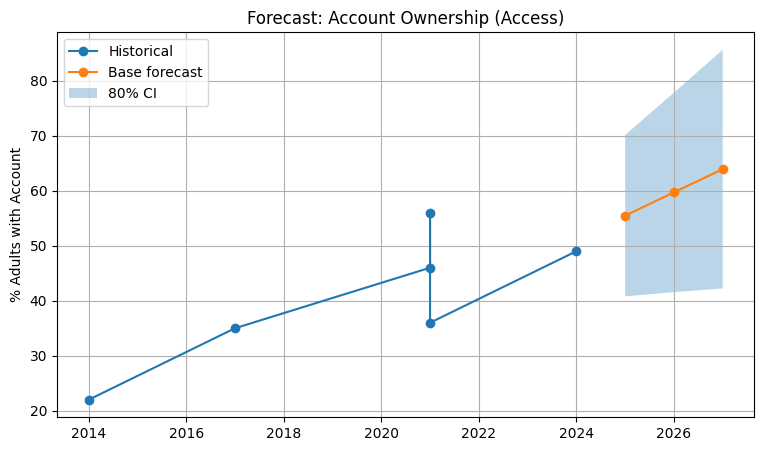

In [8]:
# Ensure datetime conversion
acc["observation_date"] = pd.to_datetime(acc["observation_date"], errors="coerce")

plt.figure(figsize=(9,5))

# Now .dt.year works
plt.plot(acc["observation_date"].dt.year, acc["value_numeric"], label="Historical", marker="o")
plt.plot(scenarios["year"], scenarios["base"], label="Base forecast", marker="o")

plt.fill_between(
    scenarios["year"],
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    alpha=0.3,
    label="80% CI"
)

plt.legend()
plt.ylabel("% Adults with Account")
plt.title("Forecast: Account Ownership (Access)")
plt.grid(True)
plt.show()


In [12]:

from statsmodels.api import OLS, add_constant


# 3. Filter for digital payments indicator
dp = obs[obs.indicator_code == "ACC_OWNERSHIP"].copy()

if dp.empty:
    print("⚠️ No records found for indicator_code = 'ACC_OWNERSHIP'")
else:
    # 4. Sort by date and create time index
    dp = dp.sort_values("observation_date")
    dp["t"] = range(len(dp))

    # 5. Regression setup
    X_dp = add_constant(dp[["t"]])   # independent variable
    y_dp = dp["value_numeric"]       # dependent variable

    # 6. Fit OLS model
    model_dp = OLS(y_dp, X_dp).fit()
    print(model_dp.summary())





                            OLS Regression Results                            
Dep. Variable:          value_numeric   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     2.963
Date:                Mon, 02 Feb 2026   Prob (F-statistic):              0.160
Time:                        15:21:29   Log-Likelihood:                -21.276
No. Observations:                   6   AIC:                             46.55
Df Residuals:                       4   BIC:                             46.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0952      7.438      4.046      0.0

c:\Users\azeb.mehrete\Documents\KAIM\KAIM-10\w10env\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
